In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark=SparkSession.builder.appName("practise").getOrCreate()

In [ ]:
py=spark.read.csv("Customer Churn.csv",inferSchema=True,header=True)

In [ ]:
py.printSchema()

root
 |-- Call  Failure: integer (nullable = true)
 |-- Complains: integer (nullable = true)
 |-- Subscription  Length: integer (nullable = true)
 |-- Charge  Amount: integer (nullable = true)
 |-- Seconds of Use: integer (nullable = true)
 |-- Frequency of use: integer (nullable = true)
 |-- Frequency of SMS: integer (nullable = true)
 |-- Distinct Called Numbers: integer (nullable = true)
 |-- Age Group: integer (nullable = true)
 |-- Tariff Plan: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Customer Value: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [ ]:
py=py.withColumnRenamed("Customer Value","CUST_VAL")
py=py.withColumnRenamed("Call  Failure","CALL_FAIL")
py=py.withColumnRenamed("Churn","CHURN_CAT")
py=py.withColumnRenamed("Complains","CUST_COMP")
py=py.withColumnRenamed("Subsription Length","SUB_LEN")
py=py.withColumnRenamed("Age","CUST_AGE")
py=py.withColumnRenamed("Status","CUST_STATUS")
py=py.withColumnRenamed("Tariff Plan","CUST_PLAN")
py=py.withColumnRenamed("Age Group","CUST_AGE_GRP")
py=py.withColumnRenamed("Seconds of Use","SEC_OF_USE")
py=py.withColumnRenamed("Frequency of Use","FREQ_OF_USE")
py=py.withColumnRenamed("Distinct Called Numbers","DIST_NUM")
py=py.withColumnRenamed('Frequency of SMS',"FREQ_SMS")
py=py.withColumnRenamed("Charge  Amount","CHARGE_AMT")
py=py.withColumnRenamed("Subscription  Length","SUB_LEN")


In [ ]:
py.show()

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

features=["CALL_FAIL","CUST_COMP","SUB_LEN","CHARGE_AMT","SEC_OF_USE","FREQ_OF_USE","FREQ_SMS","DIST_NUM","CUST_AGE_GRP","CUST_PLAN","CUST_STATUS","CUST_AGE","CUST_VAL"]

assembler=VectorAssembler(inputCols=features,outputCol="features_vectored")
output=assembler.transform(py)

correlation_matrix=Correlation.corr(output,"features_vectored","pearson").head()[0]

corr_array=correlation_matrix.toArray()

print("correlation matrix:")
#print(corr_array)

correlation matrix:
[[ 1.          0.15287875  0.16973727  0.58902801  0.50160659  0.57334936
  -0.02228238  0.50405774  0.05040629  0.19228547 -0.11464455  0.04175765
   0.12122548]
 [ 0.15287875  1.         -0.02028569 -0.03394765 -0.10495178 -0.09077422
  -0.11163256 -0.05819935  0.01997594  0.00113962  0.27140525  0.00329802
  -0.13289532]
 [ 0.16973727 -0.02028569  1.          0.07878935  0.12461763  0.10653394
   0.07631777  0.09200897  0.02145335 -0.15967975  0.14284089 -0.0024297
   0.10956476]
 [ 0.58902801 -0.03394765  0.07878935  1.          0.44673835  0.37909589
   0.09153336  0.4151979   0.27967884  0.32423241 -0.35626867  0.27895523
   0.16942771]
 [ 0.50160659 -0.10495178  0.12461763  0.44673835  1.          0.94648923
   0.10212319  0.6765363   0.02006038  0.13359296 -0.46061814  0.02084287
   0.41508724]
 [ 0.57334936 -0.09077422  0.10653394  0.37909589  0.94648923  1.
   0.10001921  0.73611353 -0.03254386  0.20645228 -0.45475181 -0.02834981
   0.40157246]
 [-0.022282

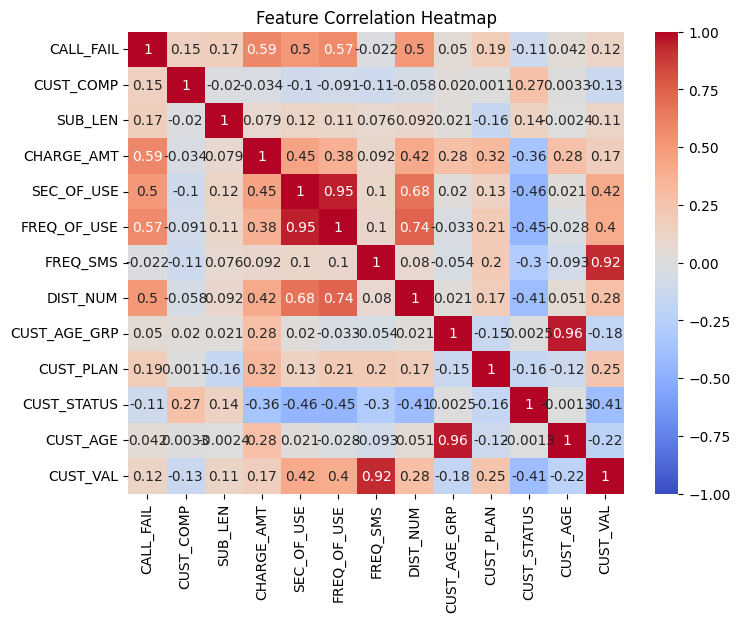

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Convert to Pandas DataFrame for easier plotting
corr_df = pd.DataFrame(corr_array, index=features, columns=features)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



# Convert 2 Pandas df for easier plotting
original_features = ["CALL_FAIL","CUST_COMP","SUB_LEN","CHARGE_AMT","SEC_OF_USE","FREQ_OF_USE","FREQ_SMS","DIST_NUM","CUST_AGE_GRP","CUST_PLAN","CUST_STATUS","CUST_AGE","CUST_VAL"]
corr_df = pd.DataFrame(corr_array, index=original_features, columns=original_features)

# Plot heatmap
plt.figure(figsize=(10,8)) # Increased figure size for better readability
sns.heatmap(corr_df, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f") # Added annotations and format
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd

def reduce_features(df, feature_cols, target_col, corr_threshold=0.9, target_corr_threshold=0.1):
    # 1. Drop highly correlated features among fea2ures
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
    df_vector = assembler.transform(df).select("features_vector")
    corr_matrix = Correlation.corr(df_vector, "features_vector", "pearson").head()[0]
    corr_array = corr_matrix.toArray()

    to_drop = set()
    for i in range(len(feature_cols)):
        for j in range(i+1, len(feature_cols)):
            if abs(corr_array[i, j]) >= corr_threshold:
                to_drop.add(feature_cols[j])
    features_after_corr_drop = [f for f in feature_cols if f not in to_drop]

    print(f"Dropped due to high collinearity: {to_drop}")

    # Calculate low correlation with target for remaining features
    corr_with_target = {}
    for feature in features_after_corr_drop:
        corr_val = df.stat.corr(feature, target_col)
        corr_with_target[feature] = corr_val

    # Drop features with low correlation to target
    low_corr_features = [f for f, corr_val in corr_with_target.items() if abs(corr_val) < target_corr_threshold]
    features_final = [f for f in features_after_corr_drop if f not in low_corr_features]

    print(f"Dropped due to low correlation with target (<{target_corr_threshold}): {low_corr_features}")
    print(f"Final selected features: {features_final}")

    return df.select(*features_final, target_col), features_final


features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']

target = 'CHURN_CAT'

df_reduced, selected_features = reduce_features(py, features, target, corr_threshold=0.9, target_corr_threshold=0.19)


Dropped due to high collinearity: {'FREQ_OF_USE', 'CUST_VAL', 'CUST_AGE'}
Dropped due to low correlation with target (<0.19): ['CALL_FAIL', 'SUB_LEN', 'CUST_AGE_GRP', 'CUST_PLAN']
Final selected features: ['CUST_COMP', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_SMS', 'DIST_NUM', 'CUST_STATUS']


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd

def reduce_features(df,features_col,target_col,corr_threshold=0.9,target_corr_threshold=0.1):
  #dropped due to highly correlated features among predictors

  assembler=VectorAssembler(inputCols=features_col,outputCol="features_vector")
  df=assembler.transform(df)

  corr=Correlation.corr(df,"features_vector","pearson").head()[0]

  corr=corr.toArray()
  to_drop=set()
  for i in range(0,len(corr)):
    for j in range(i+1,len(corr)):
      if abs(corr[i][j])>=corr_threshold:
        to_drop.add(features_col[j])
  features_not_dropped=[x for x in features_col if x not in to_drop]

  print(f"dropped due to high collinearity:{to_drop}")

  #calculate correlation for remaining features
  corr_with_target={}

  for f in features_not_dropped:
    corr_val=df.stat.corr(f,target_col)
    corr_with_target[f]= corr_val

  low_corr_features=[ f for f, corr_val in corr_with_target.items() if abs(corr_val)< target_corr_threshold]
  features_final=[f for f in features_not_dropped if f not in low_corr_features]

  print(f"dropped due to low correlation with target:{low_corr_features}")

  assembler_final=VectorAssembler(inputCols=features_final,outputCol="features_final_vector")
  df_final=assembler_final.transform(df)
  return df_final,features_final


features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']
target_col='CHURN_CAT'
corr_threshold=0.9
target_corr_threshold=0.1
df_reduced_features, selected_features_list = reduce_features(py,features,target_col,corr_threshold,target_corr_threshold)


print(f"Selected features:{selected_features_list}")

In [ ]:
def reduce_features(py,features,target_col,max_thresh=0.9,min_thresh=0.1):
  assembler=VectorAssembler(inputCols=features,outputCol="features_vector")
  py_vectored=assembler.transform(py)
  corr=Correlation.corr(py_vectored,"features_vector","pearson").head()[0]
  corr=corr.toArray()
  to_drop=set()
  for i in range(0,len(corr)):
    for j in range(1,len(corr)):
      if abs(corr[i][j])>=max_thresh:
        to_drop.add(features[j])

  features_not_dropped=[x for x in features if x not in to_drop]
  print(f"dropped due to high collinearity:{to_drop}")
  corr_with_target={}
  for f in features_not_dropped:
    corr_val=py.stat.corr(f,target_col)
    corr_with_target[f]=corr_val

  low_corr=[f for f in features_not_dropped if abs(corr_with_target[f])<min_thresh]
  features_final=[f for f in features_not_dropped if f not in low_corr]
  print(f"dropped due to low correlation with target:{low_corr}")
  assembler_final=VectorAssembler(inputCols=features_final,outputCol="features_final_vector")
  py_final=assembler_final.transform(py)
  return py_final,features_final
  features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']
target_col='CHURN_CAT'
corr_threshold=0.5
target_corr_threshold=0.1
df_reduced_features, selected_features_list = reduce_features(py,features,target_col,corr_threshold,target_corr_threshold)


print(f"Selected features:{selected_features_list}")

In [ ]:
def reduce_features(py, features, target_col, max_thresh=0.9, min_thresh=0.1):
    assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    py_vectored = assembler.transform(py)

    corr = Correlation.corr(py_vectored, "features_vector", "pearson").head()[0]
    corr = corr.toArray()

    to_drop = set()
    for i in range(0, len(corr)):
        for j in range(1, len(corr)):
            if abs(corr[i][j]) >= max_thresh:
                to_drop.add(features[j])

    features_not_dropped = [x for x in features if x not in to_drop]
    print(f"dropped due to high collinearity: {to_drop}")

    corr_with_target = {}
    for f in features_not_dropped:
        corr_val = py.stat.corr(f, target_col)
        corr_with_target[f] = corr_val

    low_corr = [f for f in features_not_dropped if abs(corr_with_target[f]) < min_thresh]
    features_final = [f for f in features_not_dropped if f not in low_corr]

    print(f"dropped due to low correlation with target: {low_corr}")

    assembler_final = VectorAssembler(inputCols=features_final, outputCol="features_final_vector")
    py_final = assembler_final.transform(py)

    return py_final, features_final
features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']
target_col='CHURN_CAT'
corr_threshold=0.5
target_corr_threshold=0.1
df_reduced_features, selected_features_list = reduce_features(py,features,target_col,corr_threshold,target_corr_threshold)


print(f"Selected features:{selected_features_list}")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def reduce_features(df, features, target_col, max_thresh=0.9, min_thresh=0.1):
    """
    Reduce features by:
    1. Dropping features highly correlated with each other (above max_thresh).
    2. Dropping features weakly correlated with the target (below min_thresh).

    Args:
      df: Spark DataFrame containing data
      features: list of feature column names
      target_col: name of target column
      max_thresh: max allowed correlation between features (default 0.9)
      min_thresh: min required correlation with target (default 0.1)

    Returns:
      df_final: DataFrame with selected features assembled into 'features_final_vector'
      features_final: List of selected feature names
    """

    # 1. Assemble features into vector column for correlation computation
    assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    df_vectored = assembler.transform(df)

    # 2. Compute Pearson correlation matrix of features
    corr_matrix = Correlation.corr(df_vectored, "features_vector", "pearson").head()[0]
    corr_array = corr_matrix.toArray()

    to_drop = set()
    # 3. Identify features to drop due to high correlation (upper triangle only)
    for i in range(len(corr_array)):
        for j in range(i + 1, len(corr_array)):
            if abs(corr_array[i][j]) >= max_thresh:
                to_drop.add(features[j])  # drop the j-th feature

    features_not_dropped = [f for f in features if f not in to_drop]
    print(f"Dropped due to high collinearity: {to_drop}")

    # 4. Calculate correlation of remaining features with target
    corr_with_target = {}
    for f in features_not_dropped:
        corr_val = df.stat.corr(f, target_col)
        corr_with_target[f] = corr_val

    # 5. Drop features with low correlation to target
    low_corr = [f for f in features_not_dropped if abs(corr_with_target[f]) < min_thresh]
    features_final = [f for f in features_not_dropped if f not in low_corr]
    print(f"Dropped due to low correlation with target: {low_corr}")

    # 6. Assemble final features into vector column
    assembler_final = VectorAssembler(inputCols=features_final, outputCol="features_final_vector")
    df_final = assembler_final.transform(df)

    return df_final, features_final

features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']
target_col='CHURN_CAT'
corr_threshold=0.9
target_corr_threshold=0.19
df_reduced_features, selected_features_list = reduce_features(py,features,target_col,corr_threshold,target_corr_threshold)


print(f"Selected features:{selected_features_list}")


In [ ]:
py_vec=py

In [ ]:
py_vec=py_vec.drop("CHARGE_AMT")

NameError: name 'py_vec' is not defined

In [ ]:
df_reduced.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import LogisticRegression

In [ ]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_assembled = assembler.transform(df_reduced)

lr=LogisticRegression(featuresCol="features",labelCol="CHURN_CAT")
train,test=df_assembled.randomSplit([0.7,0.3],seed=42)

In [ ]:
py_vectored=VectorAssembler(inputCols=features,outputCol="features")
py_vectored=py_vectored.transform(py)

In [ ]:
features=["CUST_COMP","CHARGE_AMT","SEC_OF_USE","FREQ_SMS","DIST_NUM","CUST_STATUS"]

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Assuming 'prediction' DataFrame has 'prediction' and 'Churn_indexed' columns

# Calculate Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="CHURN_CAT", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(prediction)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="CHURN_CAT", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(prediction)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="CHURN_CAT", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(prediction)
print(f"Recall: {recall:.4f}")

# Calculate F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="CHURN_CAT", predictionCol="prediction", metricName="weightedFMeasure")
f1_score = f1_evaluator.evaluate(prediction)
print(f"F1-Score: {f1_score:.4f}")

Accuracy: 0.8970
Precision: 0.8884
Recall: 0.8970
F1-Score: 0.8886


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd

def reduce_features(df,features_col,target_col,corr_threshold=0.9,target_corr_threshold=0.1):
  #dropped due to highly correlated features among predictors

  assembler=VectorAssembler(inputCols=features_col,outputCol="features_vector")
  df=assembler.transform(df)

  corr=Correlation.corr(df,"features_vector","pearson").head()[0]

  corr=corr.toArray()
  to_drop=set()
  for i in range(0,len(corr)):
    for j in range(i+1,len(corr)):
      if abs(corr[i][j])>=corr_threshold:
        to_drop.add(features_col[j])
  features_not_dropped=[x for x in features_col if x not in to_drop]

  print(f"dropped due to high collinearity:{to_drop}")

  #calculate correlation for remaining features
  corr_with_target={}

  for f in features_not_dropped:
    corr_val=df.stat.corr(f,target_col)
    corr_with_target[f]= corr_val

  low_corr_features=[ f for f, corr_val in corr_with_target.items() if abs(corr_val)< target_corr_threshold]
  features_final=[f for f in features_not_dropped if f not in low_corr_features]

  print(f"dropped due to low correlation with target:{low_corr_features}")

  assembler_final=VectorAssembler(inputCols=features_final,outputCol="features_final_vector")
  df_final=assembler_final.transform(df)
  return df_final,features_final


features = ['CALL_FAIL', 'CUST_COMP', 'SUB_LEN', 'CHARGE_AMT', 'SEC_OF_USE', 'FREQ_OF_USE',
            'FREQ_SMS', 'DIST_NUM', 'CUST_AGE_GRP', 'CUST_PLAN', 'CUST_STATUS', 'CUST_AGE', 'CUST_VAL']
target_col='CHURN_CAT'
corr_threshold=0.9
target_corr_threshold=0.1
dselected_features=reduce_features(py,features,target_col,corr_threshold,target_corr_threshold)


print(f"Selected features:{dselected_features}")

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler # Import VectorAssembler

# Assuming your dataframe is `df_reduced` and features are in the selected columns
# Also assume your target column is 'CHURN_CAT'

# Define the feature columns based on the selected_features list
# selected_features was determined in cell n9areiB9swf_

assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
df_assembled = assembler.transform(df_reduced)

# Step 1: Split data into train and test (e.g., 70% train, 30% test)
train_df, test_df = df_assembled.randomSplit([0.7, 0.3], seed=42)

# Step 2: Define your model
lr = LogisticRegression(featuresCol="features", labelCol="CHURN_CAT")

# Step 3: Fit model on training data
lr_model = lr.fit(train_df)

# Step 4: Make predictions on training and test sets
train_predictions = lr_model.transform(train_df)
test_predictions = lr_model.transform(test_df)

# Step 5: Define evaluator (for accuracy or other metric)
evaluator = MulticlassClassificationEvaluator(labelCol="CHURN_CAT", predictionCol="prediction", metricName="accuracy")

# Step 6: Evaluate performance
train_acc = evaluator.evaluate(train_predictions)
test_acc = evaluator.evaluate(test_predictions)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Interpretation:
if train_acc > test_acc + 0.1:
    print("Warning: Possible Overfitting detected")
elif train_acc < 0.6 and test_acc < 0.6:
    print("Warning: Possible Underfitting detected")
else:
    print("Model fit looks good")

Training Accuracy: 0.9056
Test Accuracy: 0.8970
Model fit looks good


In [ ]:
model=lr.fit(train)

In [ ]:
prediction=model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when,col

In [ ]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
